In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
from demregpy import dn2dem
import demregpy
import numpy.ma as ma

import glob
from sunpy.net import Fido, attrs as a
from astropy.visualization import wcsaxes

from sys import path as sys_path
# Change to your local copy's location...
sys_path.append('/home/adithya/Desktop/AIA_temp/DEM/demreg-master/python/')
from dn2dem_pos import dn2dem_pos

import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map
from sunpy.net import Fido, attrs
from sunpy.map import Map

from astropy import units as u, time as time
from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing
from aiapy.calibrate import degradation, register, update_pointing, correct_degradation
from aiapy.calibrate.util import get_correction_table

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
#Load the files from the folder 
fdir = '/home/adithya/Desktop/AIA_temp/DEM/AR_13304_1.5_level_data/'
files = sorted(glob.glob(fdir + 'AIA*.fits'))
print(files)
maps = [sunpy.map.Map(file) for file in files]

maps = [Map(file) for file in files]
maps = sorted(maps, key=lambda x: x.wavelength)
#maps = [aiaprep(m) for m in maps]
maps = [correct_degradation(m)/m.exposure_time for m in maps]

wvn0 = [m.meta['wavelnth'] for m in maps]
srt_id = sorted(range(len(wvn0)), key=wvn0.__getitem__)

maps = [maps[i] for i in srt_id]
print([m.meta['wavelnth'] for m in maps])

wvn = [m.meta['wavelnth'] for m in maps]
worder=np.argsort(wvn)

durs = [m.meta['exptime'] for m in maps]

durs=np.array(durs)
wvn=np.array(wvn)
#print('duration -',durs)

['/home/adithya/Desktop/AIA_temp/DEM/AR_13304_1.5_level_data/AIA20230515_0230_0094.fits', '/home/adithya/Desktop/AIA_temp/DEM/AR_13304_1.5_level_data/AIA20230515_0230_0131.fits', '/home/adithya/Desktop/AIA_temp/DEM/AR_13304_1.5_level_data/AIA20230515_0230_0171.fits', '/home/adithya/Desktop/AIA_temp/DEM/AR_13304_1.5_level_data/AIA20230515_0230_0193.fits', '/home/adithya/Desktop/AIA_temp/DEM/AR_13304_1.5_level_data/AIA20230515_0230_0211.fits', '/home/adithya/Desktop/AIA_temp/DEM/AR_13304_1.5_level_data/AIA20230515_0230_0335.fits']
[94, 131, 171, 193, 211, 335]


In [3]:
trin=io.readsav('/home/adithya/Desktop/AIA_temp/DEM/aia_tresp_en.dat')

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

#print(nt,nf)

temps=np.logspace(5.7,7.0,num=31)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

mtemps=([np.mean([(temps[i]),(temps[i+1])]) \
             for i in np.arange(0,len(temps)-1)])
log_temps = np.log10(temps)
'''
print('tempertures-',temps)
print('No. of Bins - ',len(temps))
print("===============================================================================================")


print('log Temperature - ',log_temps)

print('Mid Temperature - ', mtemps)
print(len(mtemps))
print("===============================================================================================")
print('Mid value log tempertures-',mlogt)
print(len(mlogt))
'''

'\nprint(\'tempertures-\',temps)\nprint(\'No. of Bins - \',len(temps))\nprint("===============================================================================================")\n\n\nprint(\'log Temperature - \',log_temps)\n\nprint(\'Mid Temperature - \', mtemps)\nprint(len(mtemps))\nprint("===============================================================================================")\nprint(\'Mid value log tempertures-\',mlogt)\nprint(len(mlogt))\n'

In [4]:
nx = int(maps[0].dimensions.x.value)
ny = int(maps[0].dimensions.y.value)
nf = len(files)
data = np.zeros([nx, ny, nf])

#convert from our list to an array of data
for j in np.arange(nf):
    data[:,:,j]=maps[j].data
data[data < 0]=0
serr_per=10.0
#errors in dn/px/s


npix=1024.**2/(nx*ny)
edata=np.zeros([nx,ny,nf])
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*[94,131,171,193,211,335]/3397.0
rdnse=1.15*np.sqrt(npix)/npix
drknse=0.17
qntnse=0.288819*np.sqrt(npix)/npix
for j in np.arange(nf):
    etemp=np.sqrt(rdnse**2.+drknse**2.+qntnse**2.+(dn2ph[j]*abs(data[:,:,j]))/(npix*dn2ph[j]**2))
    esys=serr_per*data[:,:,j]/100.
    edata[:,:,j]=np.sqrt(etemp**2. + esys**2.)
    

## DEM calculation

In [13]:
#Cutting the region of interest  

r1=0#610      
r2=1023#780
c1=0#550
c2=1023#720
dn_in=data[r1:r2,c1:c2,:]
edn_in=edata[r1:r2,c1:c2,:]


dem0, edem0, elogt0, chisq0, dn_reg0 = dn2dem_pos(dn_in, edn_in, trmatrix, tresp_logt, temps,max_iter=100, rgt_fact=1.5)



100%|██████████| 10.5k/10.5k [03:39<00:00, 47.6 x10^2 DEM/s]


LinAlgError: SVD did not converge

In [12]:
# use this for whole sun DEM 
dem0, edem0, elogt0, chisq0, dn_reg0 = dn2dem_pos(data, edata, trmatrix, tresp_logt, temps,max_iter=100, rgt_fact=1.5)


100%|██████████████████████████████| 10.5k/10.5k [02:58<00:00, 58.7 x10^2 DEM/s]


## DEM PLOTS

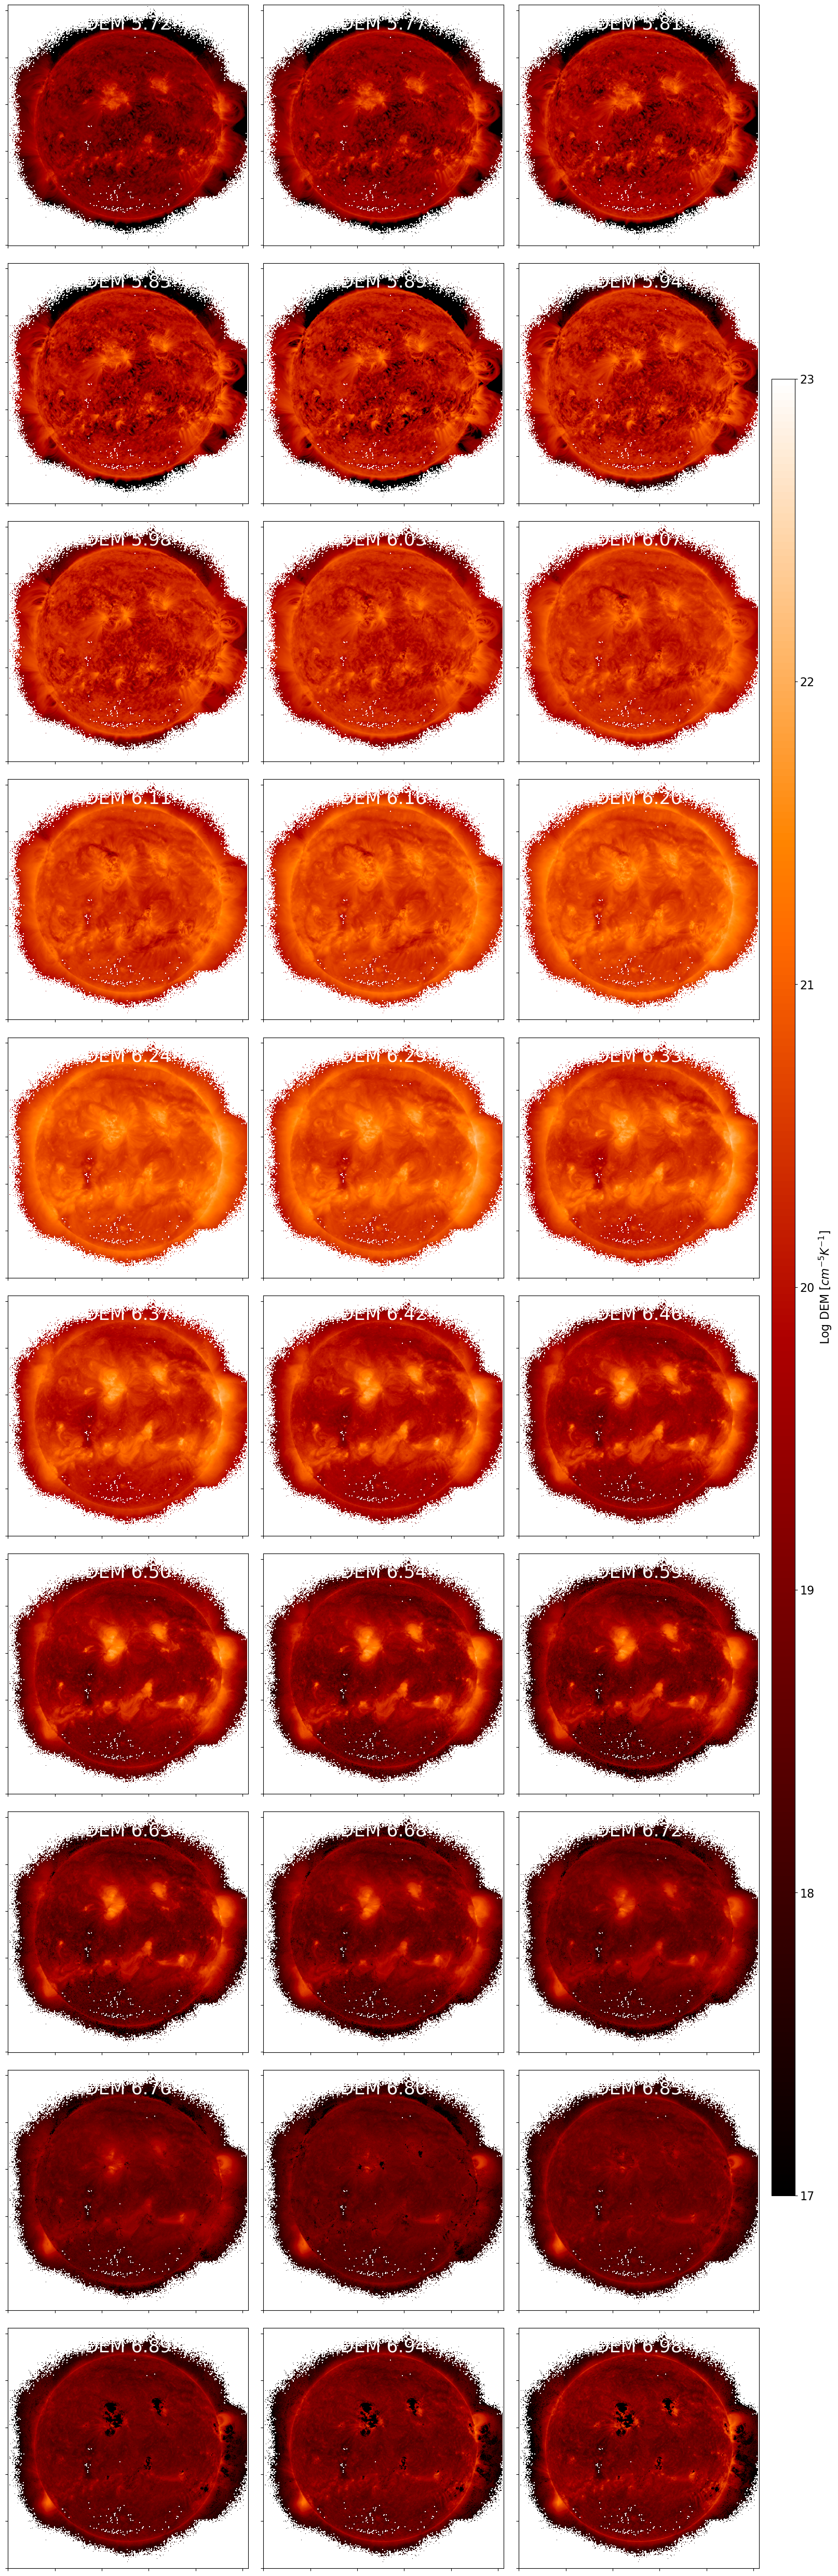

In [13]:
num_rows = 10
num_cols = 3
fig_width = 15  # Adjust this value based on your preference

fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_width * (num_rows / num_cols)))


vmin = 17
vmax = 23


images = []

for j, ax in enumerate(axes.flat):
    im = ax.imshow(np.log10(dem0[:, :, j]),'hinodexrt', origin='lower', vmin=vmin, vmax=vmax)
    title = 'DEM %.2f' % mlogt[j]
    #ax.set_title(title)
    ax.text(0.5, 0.90, title, color='white', ha='center', transform=ax.transAxes, fontsize=25)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    # Append the mappable object to the list
    images.append(im)

# Use the list of mappable objects for the colorbar

plt.subplots_adjust(right=0.85)

# Use the list of mappable objects for the colorbar
cbar_ax = fig.add_axes([1.0, 0.15, 0.03, 0.7])  # [x, y, width, height]


cbar=plt.colorbar(images[0], cax=cbar_ax, orientation='vertical')
cbar.set_label(r'Log DEM [$cm^{-5} K^{-1}$]')
plt.tight_layout()
plt.savefig('DEM_map_AR13304.png', dpi=300, bbox_inches='tight')

plt.show()


## EM calcualtion

In [14]:
em0 = np.zeros_like(dem0)
em0_temp= np.zeros_like(dem0)

for j in range(0,30):
    em0[:, :, j] = dem0[:, :, j] *(temps[j + 1] - temps[j])
    em0_temp[:, :, j] = em0[:, :, j]*(mtemps[j])
        #if you want to measure for particular bins i.e not for all  bins then mention like em0[:, :,1:5] for bin 1 to 4
#total_em = np.sum(em0[:, :], axis=2)
#total_weighted_em = np.sum(em0_temp[:, :],axis=2)
#mean_temp = (total_weighted_em)/(total_em)

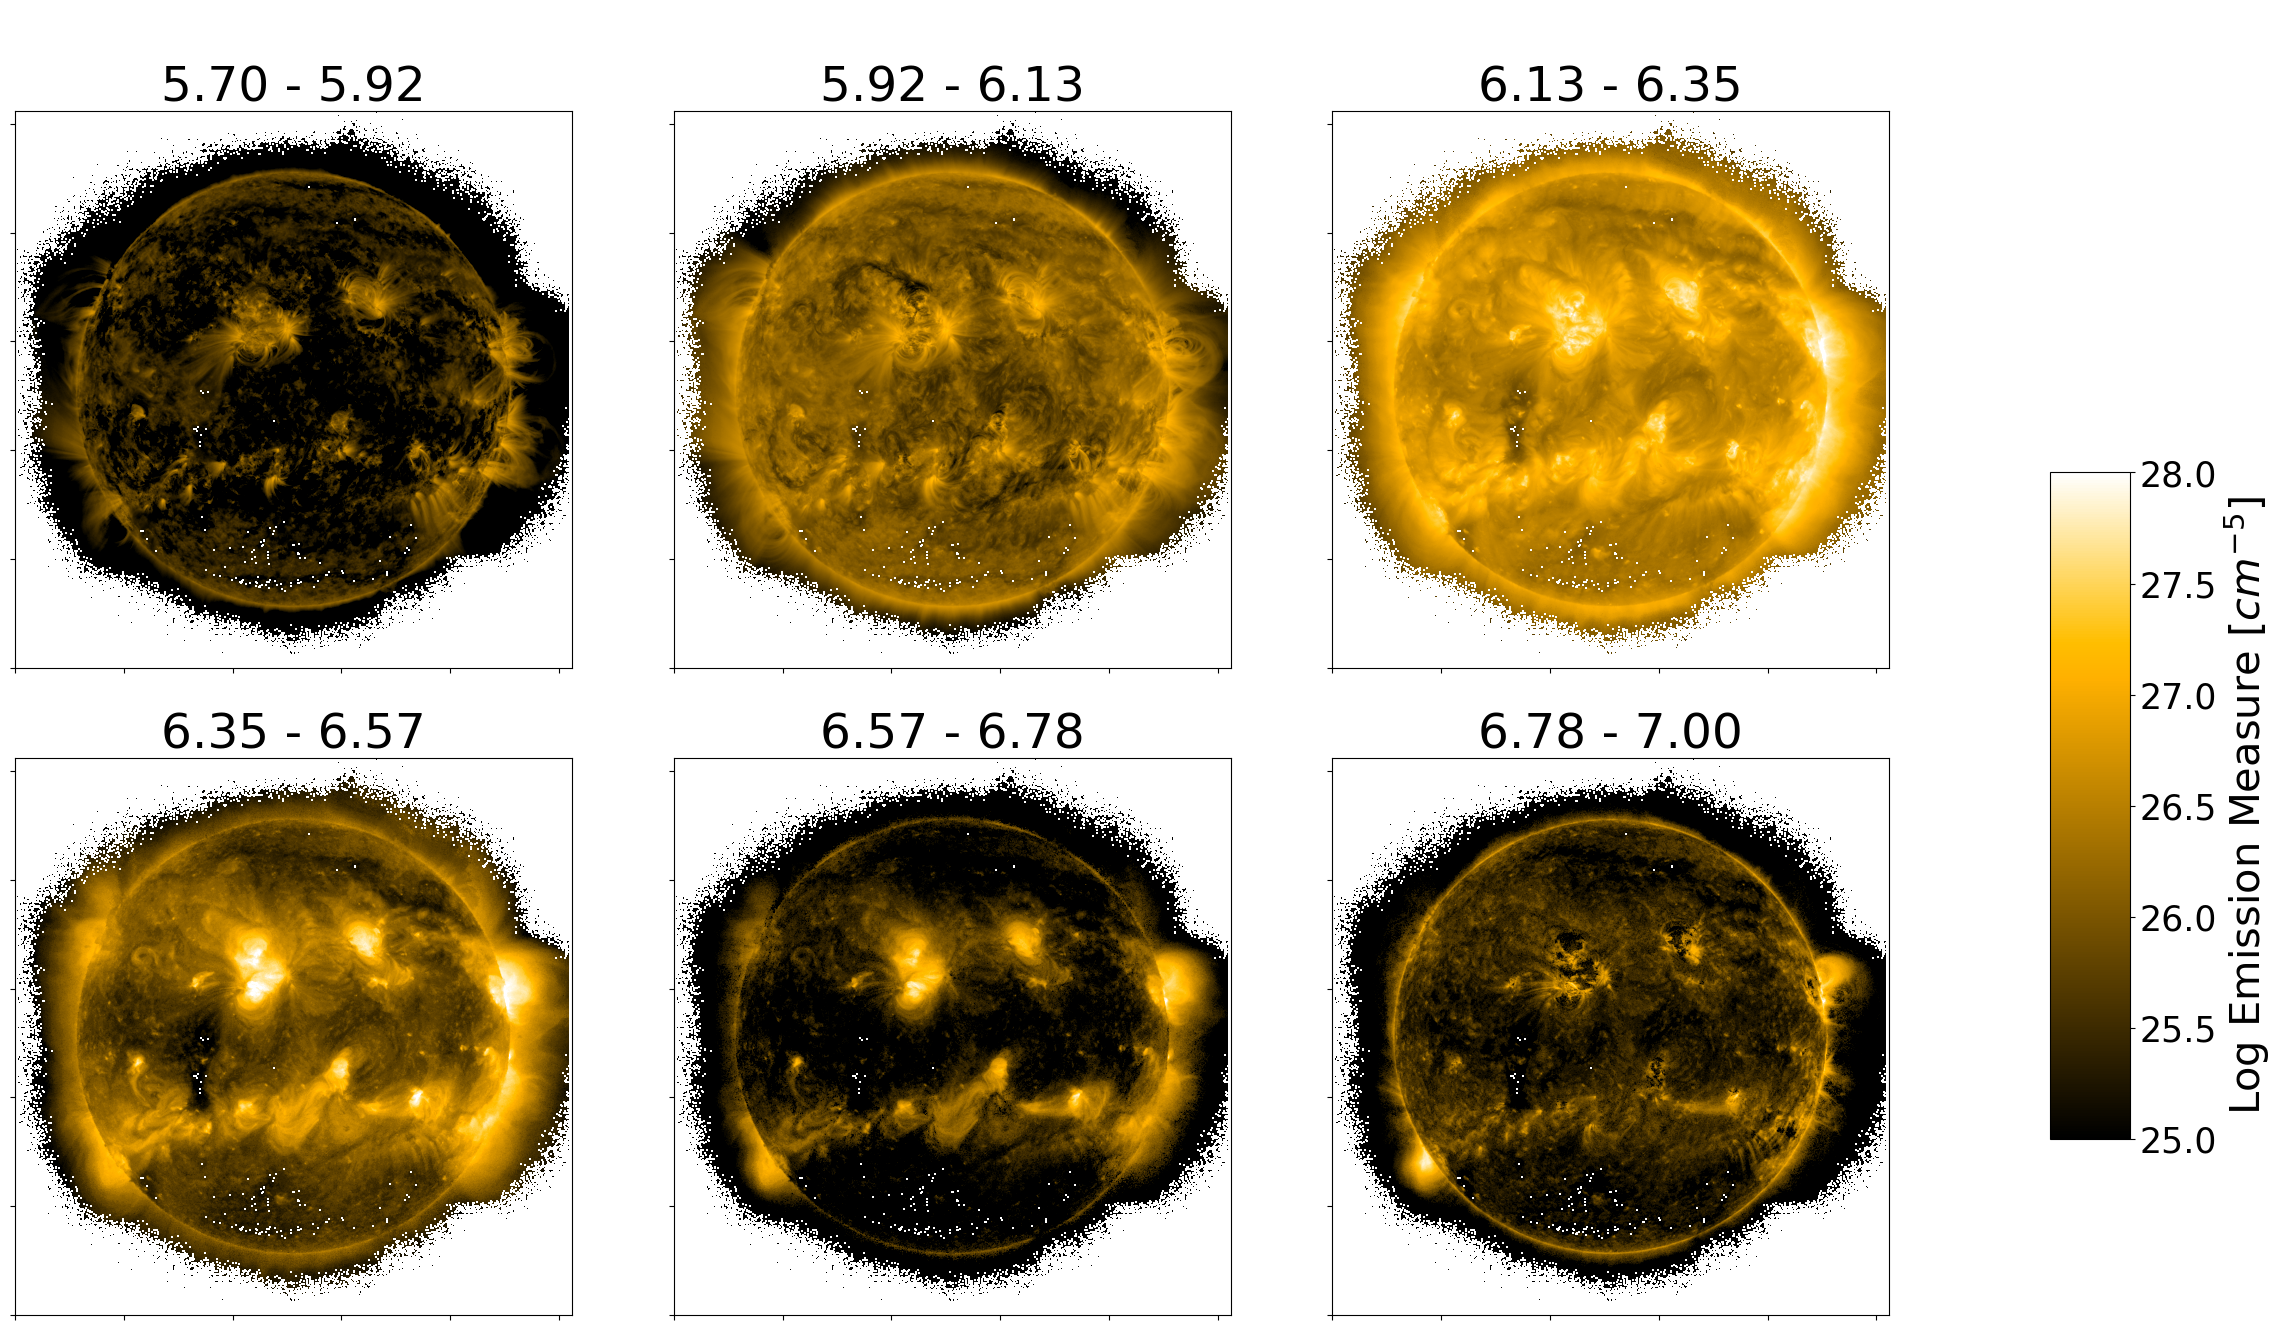

In [18]:

num_rows = 2
num_cols = 3
fig_width = 20  # Adjust this value based on your preference

fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_width * (num_rows / num_cols)))
image = []

vmin = 25
vmax = 28
#prev_temp = log_temps[0]

for j, ax in enumerate(axes.flat):
    # Calculate column sum for the current subplot
    column_em = np.sum(em0[:, :, 5*j:5*(j+1)], axis=2)
    
    # Plot the log scale
    im = ax.imshow(np.log10(column_em), 'sdoaia171', origin='lower', vmin=vmin, vmax=vmax)

    # Set the title based on log_temps values
    title = '\n%.2f - %.2f' % (log_temps[5*j],log_temps[5*j+5])


    ax.set_title(title,fontsize=35)
    # Set the title directly on the image
    #ax.text(0.5, 0.90, title, color='purple', ha='center', transform=ax.transAxes, fontsize=35)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    # Update the previous temperature value
    #prev_temp = log_temps[j+4]
    
    # Append the mappable object to the list
    image.append(im)

plt.subplots_adjust(right=0.85)

# Use the list of mappable objects for the colorbar
cbar_ax = fig.add_axes([1.05, 0.15, 0.04, 0.5])  # [x, y, width, height]

cbar = plt.colorbar(image[0], cax=cbar_ax, orientation='vertical')
cbar.set_label(r'Log Emission Measure [$cm^{-5}$]', fontsize=30)
cbar.ax.tick_params(labelsize=25)
plt.tight_layout()


plt.savefig('EM_map_13304.png', dpi=300, bbox_inches='tight')
plt.show()


# Mean temperature

In [15]:
      
total_em = np.sum(em0[:, :,0:30], axis=2)
total_weighted_em = np.sum(em0_temp[:, :,0:30],axis=2)
mean_temp = (total_weighted_em)/(total_em)

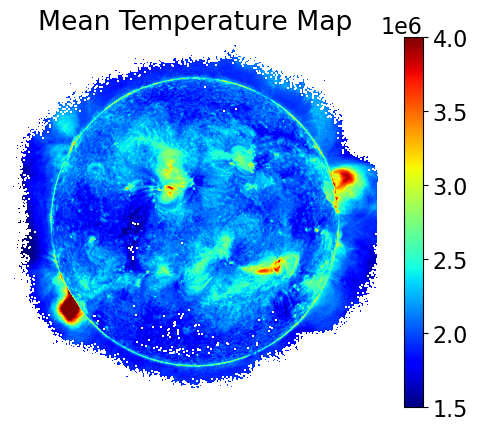

In [16]:
from astropy.io import fits
plt.imshow(mean_temp, 'jet',origin='lower',vmin=1500000,vmax=4000000)
#plt.imshow(np.log10(mean_temp), 'hinodexrt', origin='lower')

plt.title('Mean Temperature Map')
plt.axis('off')
hdu=fits.PrimaryHDU(mean_temp)
hdu.writeto('Temp_map_13304.fits',overwrite=True)
plt.colorbar()
plt.savefig('Mean temperature_fulldisk_13304.png', dpi=1000, bbox_inches='tight')
plt.show()



In [ ]:

num_rows = 2
num_cols = 3
fig_width = 20  # Adjust this value based on your preference

fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_width * (num_rows / num_cols)))
temp_image = []

vmin = 10000
vmax = 3500000
#prev_temp = log_temps[0]

for j, ax in enumerate(axes.flat):
    # Calculate column sum for the current subplot
    column_em = np.sum(em0[:, :, 5*j:5*(j+1)], axis=2)
    mean_temp_em = np.sum(em0_temp[:, :, 5*j:5*(j+1)], axis=2)
    
    
        
    mean_temp = (mean_temp_em)/(coloumn_em)
   
    # Plot the log scale
    im = ax.imshow(mean_temp, 'hinodexrt', origin='lower',vmin=vmin,vmax=vmax)

    # Set the title based on log_temps values
    title = '\n%.2f - %.2f' % (log_temps[5*j],log_temps[5*j+5])


    #ax.set_title(title)
    # Set the title directly on the image
    ax.text(0.5, 0.90, title, color='white', ha='center', transform=ax.transAxes, fontsize=35)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    # Update the previous temperature value
    #prev_temp = log_temps[j+4]
    
    # Append the mappable object to the list
    temp_image.append(im)

plt.subplots_adjust(right=0.85)

# Use the list of mappable objects for the colorbar
cbar_ax = fig.add_axes([1.1, 0.15, 0.04, 0.7])  # [x, y, width, height]

cbar = plt.colorbar(temp_image[5], cax=cbar_ax, orientation='vertical')

cbar.ax.tick_params(labelsize=40)

cbar.set_label(r'Temperature [$K$]', fontsize=30)

plt.tight_layout()
plt.show()


In [ ]:
# Assuming you have dem0, em0, and temps defined somewhere in your code
em0 = np.zeros_like(dem0)
for j in range(0,9):
    em0[:, :, j] = dem0[:, :, j] * (temps[j + 1] - temps[j])

tem = np.sum(em0[:, :,0:4], axis=2)
print('test',em0[250,250,0]+em0[250,250,1]+em0[250,250,2]+em0[250,250,3])
print('Sum',tem[250,250])
plt.imshow(np.log10(tem), 'hinodexrt', origin='lower')
plt.colorbar()
plt.show()

In [ ]:
yr=[2e16,4e23]
xr=[5.7,7.2]
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0[94,106,:],xerr=elogt0[94,106,:],yerr=edem0[94,106,:],fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0)
plt.errorbar(mlogt,dem0[100,100,:],xerr=elogt0[100,100,:],yerr=edem0[94,106,:],fmt='ob',\
             ecolor='lightskyblue', elinewidth=3, capsize=0)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')

plt.show()

In [ ]:
(int(np.floor(np.argmax(dem0[:,:,3])/200)),
np.mod(np.argmax(dem0[:,:,3]),200))

In [ ]:
plt.imshow(np.sqrt(maps[2].data[r1:r2,c1:c2]),vmax=np.sqrt(4000), cmap=maps[2].cmap, origin='lower')
#channels

In [ ]:


fig, axes = plt.subplots(2, 3, figsize=(12, 12))

# Set a common color scale range for all subplots
vmin = 23
vmax = 29

t1 = 501187
t2 = 10000000

# Initialize a list to store the mappable objects
em_images = []

for j, ax in enumerate(axes.flat):
    em0 = np.copy(dem0)
    em0[:, :, j] = dem0[:, :, j] * (t2 - t1)
    em_im = ax.imshow(np.log10(em0[:, :, j]), 'twilight_shifted', origin='lower', vmin=vmin, vmax=vmax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # Append the mappable object to the list
    em_images.append(em_im)

# Create a single colorbar for all subplots
cbar = plt.colorbar(em_images[2], ax=axes, orientation='vertical', fraction=0.02, pad=0.1)

# Set a label for the colorbar
#bar.set_label('Your Colorbar Label', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


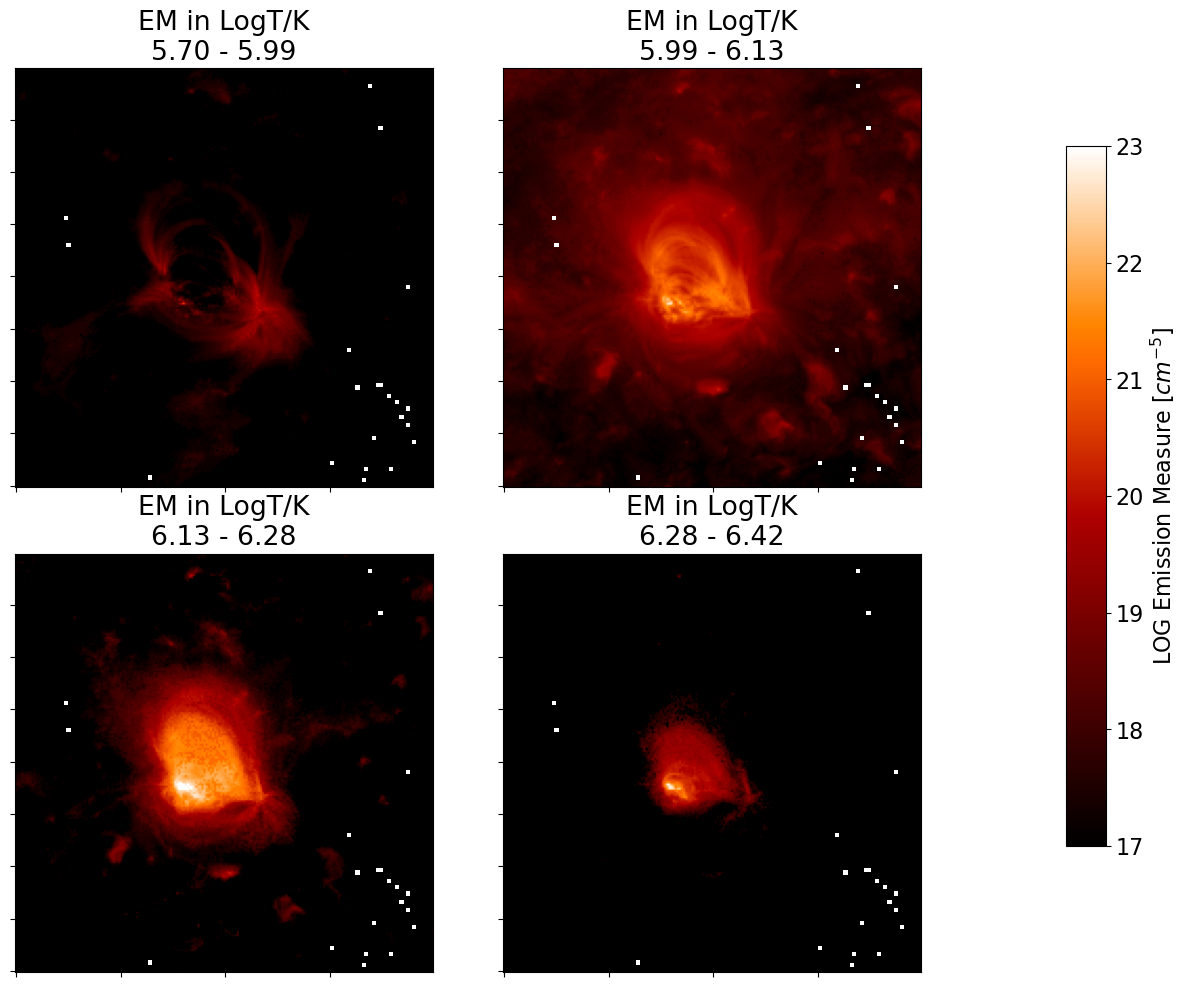

In [215]:

vmin = 26
vmax = 28

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

image = []

# Initialize the previous temperature value
prev_temp = log_temps[0]

for j, ax in enumerate(axes.flat):
    # Calculate column sum for the current subplot
    column_sum = np.sum(em0[:, :, 2*j:2*(j+1)], axis=2)
    
    # Plot the log scale
    im = ax.imshow(np.log10(column_sum), 'hinodexrt', origin='lower', vmin=vmin, vmax=vmax)

    # Set the title based on log_temps values
    title = 'EM in LogT/K\n%.2f - %.2f' % (prev_temp, log_temps[j+2])

    ax.set_title(title)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    # Update the previous temperature value
    prev_temp = log_temps[j+2]
    
    # Append the mappable object to the list
    image.append(im)

plt.subplots_adjust(right=0.85)

# Use the list of mappable objects for the colorbar
cbar_ax = fig.add_axes([1.1, 0.15, 0.04, 0.7])  # [x, y, width, height]

cbar=plt.colorbar(images[0], cax=cbar_ax, orientation='vertical')
cbar.set_label(r'LOG Emission Measure [$cm^{-5}$]')
plt.tight_layout()
plt.show()


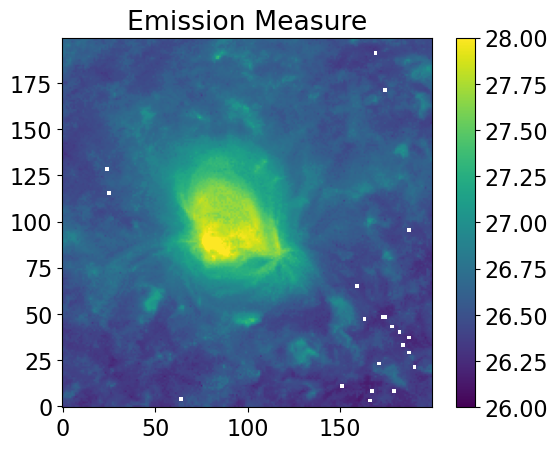

In [158]:
em0 = np.zeros_like(dem0)
em0_temp= np.zeros_like(dem0)

for j in range(0,9):
    em0[:, :, j] = dem0[:, :, j] *(temps[j + 1] - temps[j])
    em0_temp[:, :, j] = em0[:, :, j]*(mtemps[j])
    
    #if you want to measure for particular bins i.e not for all  bins then mention like em0[:, :,1:5] for bin 1 to 4
    coloumn_em = np.sum(em0[:, :], axis=2)
    mean_temp_em = np.sum(em0_temp[:, :],axis=2)
mean_temp = (mean_temp_em)/(coloumn_em)
plt.imshow(np.log10(coloumn_em), 'viridis', vmin=26,vmax=28,origin='lower')

plt.colorbar()
plt.title('Emission Measure')
plt.show()
